## Connecting to Federated Query Executed System

### Presto
``
conn = presto.Connection(host="presto", port=8080, user="demo")
cur = conn.cursor()
``
### Drill
``drill = PyDrill(host='drill', port=8047)``
### Spark
TODO
### Hive
TODO


In [1]:
%pip install pathlib
%pip install jinja2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pathlib import Path
import jinja2
import prestodb.dbapi as presto
from pydrill.client import PyDrill
import pandas as pd
import time

In [4]:
# configure sources
def get_sources_config(scale,**kwargs):
    """Returns a dict with tabels maped to sources"""
    mapped = {
        "lineitem":f"{kwargs['li_source']}.public.{kwargs['li_source'][:-1]}_{scale}_lineitem",
        "orders":f"{kwargs['o_source']}.public.{kwargs['o_source'][:-1]}_{scale}_orders",
        "customer":f"{kwargs['c_source']}.public.{kwargs['c_source'][:-1]}_{scale}_customer",
        "part":f"{kwargs['pa_source']}.public.{kwargs['pa_source'][:-1]}_{scale}_part",
        "supplier":f"{kwargs['s_source']}.public.{kwargs['s_source'][:-1]}_{scale}_supplier",
        "partsupp":f"{kwargs['ps_source']}.public.{kwargs['ps_source'][:-1]}_{scale}_partsupp",
        "nation":f"{kwargs['n_source']}.public.{kwargs['n_source'][:-1]}_{scale}_nation",
        "region":f"{kwargs['r_source']}.public.{kwargs['r_source'][:-1]}_{scale}_region"
    }
    return mapped

In [5]:
def get_queries():
    return [q for q in Path("./queries").iterdir()]

def render_queries(sources_config,queries_path):
    """Returns a dict where the key is the tpch query name and the value is the rendered query"""
    result = {}
    for path in queries_path:
        key = path.name.split(".")[0]
        value = jinja2.Template(path.read_text()).render(**sources_config)
        result[key]=value
    return result

In [6]:
class Presto():
    def __init__(self,host="presto",port=8080,user="demo"):
        self.conn = presto.Connection(host="presto", port=8080, user="demo")
        self.cur = self.conn.cursor()
    
    def run_query(self,sql,show=False):
        self.cur.execute(sql)
        result = self.cur.fetchall()
        if show:
            return result

In [6]:
class Drill(PyDrill):
    def __init__(self,**kwargs):
        PyDrill.__init__(self, **kwargs)
        
    def run_query(self,sql,timeout=100000,show=False):
        if show:
            return self.query(sql,timeout=timeout).to_dataframe()
        return self.query(sql,timeout=timeout)

In [7]:
drill = Drill(host='drill', port=8047)

if not drill.is_active():
    raise ValueError('Please run Drill first')

presto = Presto()

# Benchmark

In [8]:
def benchmark(system,query,iterations=1):
    sum = 0
    count = 0
    for _ in range(iterations):
        count = count + 1
        start = time.time()
        system.run_query(query)
        end = time.time()
        sum = sum + (end - start)
    return sum/count

In [7]:
import re

def sort_human(l):
    convert = lambda text: float(text) if text.isdigit() else text
    alphanum = lambda key: [convert(c) for c in re.split('([-+]?[0-9]*\.?[0-9]*)', key)]
    l.sort(key=alphanum)
    return l

In [8]:
mixed_sources={
    "li_source":"pg1",
    "o_source":"mysql1",
    "c_source":"pg3",
    "pa_source":"pg4",
    "s_source":"mysql1",
    "ps_source":"mysql2",
    "n_source":"pg3",
    "r_source":"pg4",
}
config_sf1_mixed = get_sources_config(scale="sf1",**mixed_sources)
query_dict = render_queries(sources_config=config_sf1_mixed,queries_path=get_queries())

In [11]:
# q2, q9, q11 -> cannot run as ps_supplycost column by partsupp is not shown by presto
presto_benchmark_results=[]

In [9]:
sorted_query_keys = sort_human(list(query_dict.keys()))

In [13]:
def run_and_save_results(system,queries,iterations=1):
    f = Path(f"{type(system).__name__}.csv").open("a")
    log = Path("errors.log").open("a")
    for query in queries[:-1]:
        try:
            benchmark_result = benchmark(system,query_dict[query],iterations=iterations)
            f.write(str(benchmark_result))
            time.sleep(10)
        except Exception as e:
            f.write("0")
            log.write(str(e))
        f.write(",")
        f.flush()
    try:
        benchmark_result = benchmark(system,query_dict[queries[-1]],iterations=iterations)
        f.write(str(benchmark_result))
    except Exception as e:
        f.write("0")
        log.write(str(e))
    f.write("\n")
    log.write("\n")
    log.close()
    f.close()

In [ ]:
run_and_save_results(presto,sorted_query_keys,iterations=10)

In [ ]:
pg_sources={
    "li_source":"pg1",
    "o_source":"pg2",
    "c_source":"pg3",
    "pa_source":"pg4",
    "s_source":"pg2",
    "ps_source":"pg1",
    "n_source":"pg3",
    "r_source":"pg4",
}
config_sf1_pg = get_sources_config(scale="sf1",**pg_sources)
query_dict = render_queries(sources_config=config_sf1_pg,queries_path=get_queries())

In [ ]:
run_and_save_results(presto,sorted_query_keys,iterations=10)

In [ ]:
mysql_sources={
    "li_source":"mysql1",
    "o_source":"mysql2",
    "c_source":"mysql1",
    "pa_source":"mysql2",
    "s_source":"mysql2",
    "ps_source":"mysql1",
    "n_source":"mysql2",
    "r_source":"mysql1",
}
config_sf1_mysql = get_sources_config(scale="sf1",**mysql_sources)
query_dict = render_queries(sources_config=config_sf1_mysql,queries_path=get_queries())

In [ ]:
run_and_save_results(presto,sorted_query_keys,iterations=10)

### Benchmarking Drill 

In [ ]:
drill_benchmark_results=[]

config_sf1_mixed = get_sources_config(scale="sf1",**mixed_sources)
config_sf1_pg = get_sources_config(scale="sf1",**pg_sources)
config_sf1_mysql = get_sources_config(scale="sf1",**mysql_sources)

In [ ]:
# set mempor usage to 100%
drill.run_query("ALTER SYSTEM SET `planner.memory.percent_per_query` = 1.0")

In [ ]:
query_dict = render_queries(sources_config=config_sf1_mixed,queries_path=get_queries())
run_and_save_results(drill,sorted_query_keys,iterations=10)

In [ ]:
query_dict = render_queries(sources_config=config_sf1_pg,queries_path=get_queries())
run_and_save_results(drill,sorted_query_keys[5:],iterations=10)

In [ ]:
query_dict = render_queries(sources_config=config_sf1_mysql,queries_path=get_queries())
run_and_save_results(drill,sorted_query_keys[:5],iterations=10)
time.sleep(60)
run_and_save_results(drill,sorted_query_keys[5:9],iterations=10)
time.sleep(60)
run_and_save_results(drill,sorted_query_keys[9:],iterations=10)

In [13]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
presto_results = pd.read_csv("Presto.csv")
drill_results = pd.read_csv("Drill.csv")

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

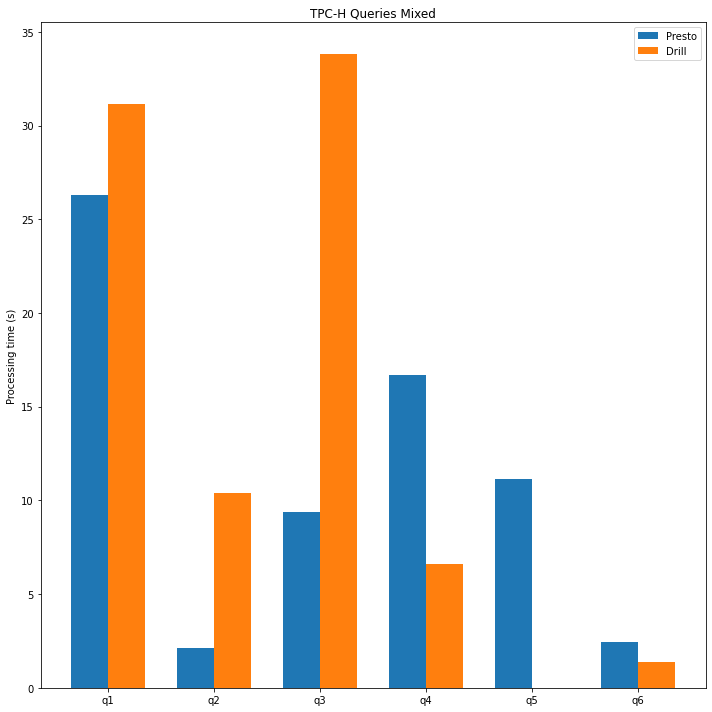

In [36]:
labels = sorted_query_keys[:6]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, presto_results.iloc[0][:6], width, label='Presto')
rects2 = ax.bar(x + width/2, drill_results.iloc[0][:6], width, label='Drill')

ax.set_ylabel('Processing time (s)')
ax.set_title('TPC-H Queries Mixed')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

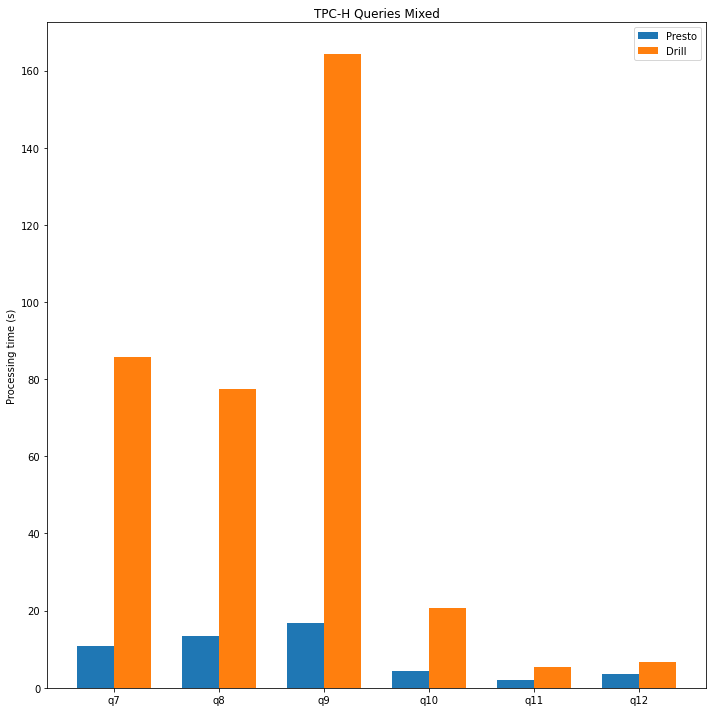

In [20]:
labels = sorted_query_keys[6:]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, presto_results.iloc[0][6:], width, label='Presto')
rects2 = ax.bar(x + width/2, drill_results.iloc[0][6:], width, label='Drill')

ax.set_ylabel('Processing time (s)')
ax.set_title('TPC-H Queries Mixed')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

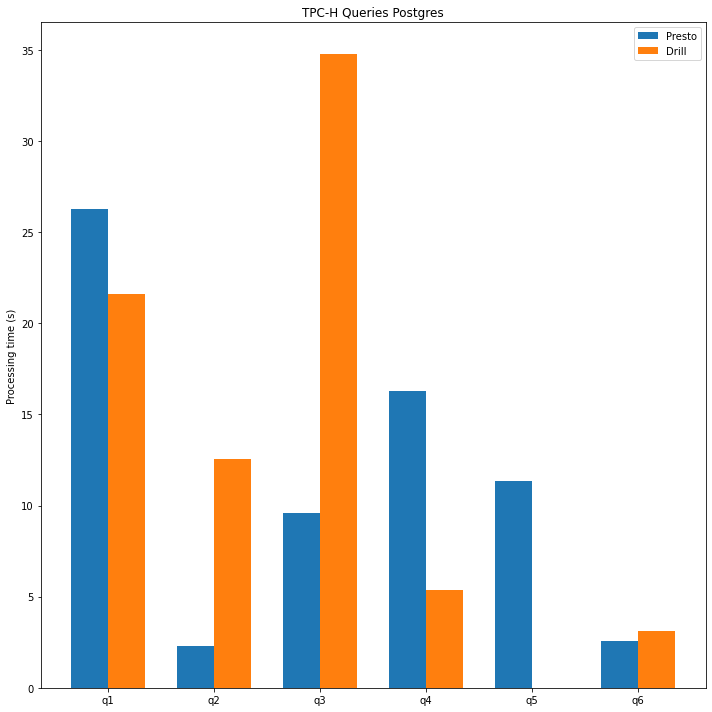

In [21]:
labels = sorted_query_keys[:6]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, presto_results.iloc[1][:6], width, label='Presto')
rects2 = ax.bar(x + width/2, drill_results.iloc[1][:6], width, label='Drill')

ax.set_ylabel('Processing time (s)')
ax.set_title('TPC-H Queries Postgres')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

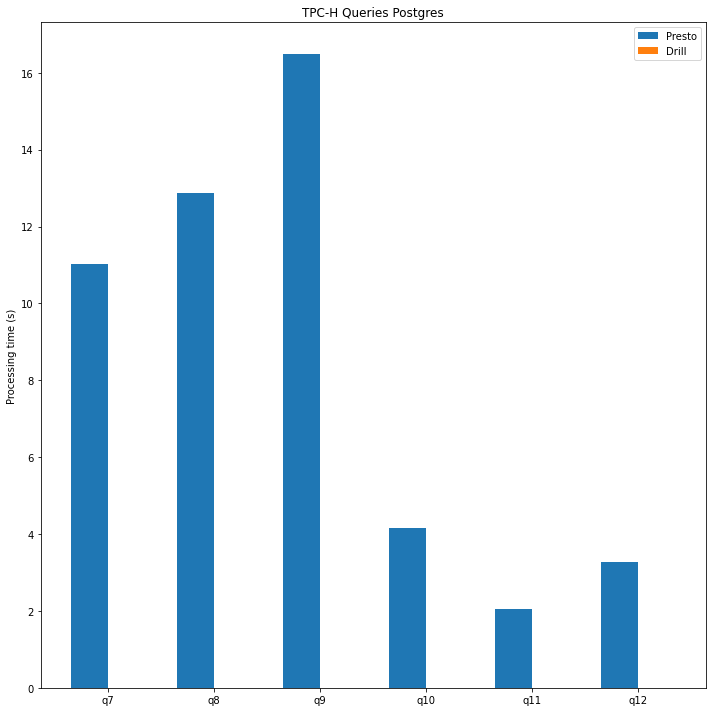

In [22]:
labels = sorted_query_keys[6:]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, presto_results.iloc[1][6:], width, label='Presto')
rects2 = ax.bar(x + width/2, drill_results.iloc[1][6:], width, label='Drill')

ax.set_ylabel('Processing time (s)')
ax.set_title('TPC-H Queries Postgres')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

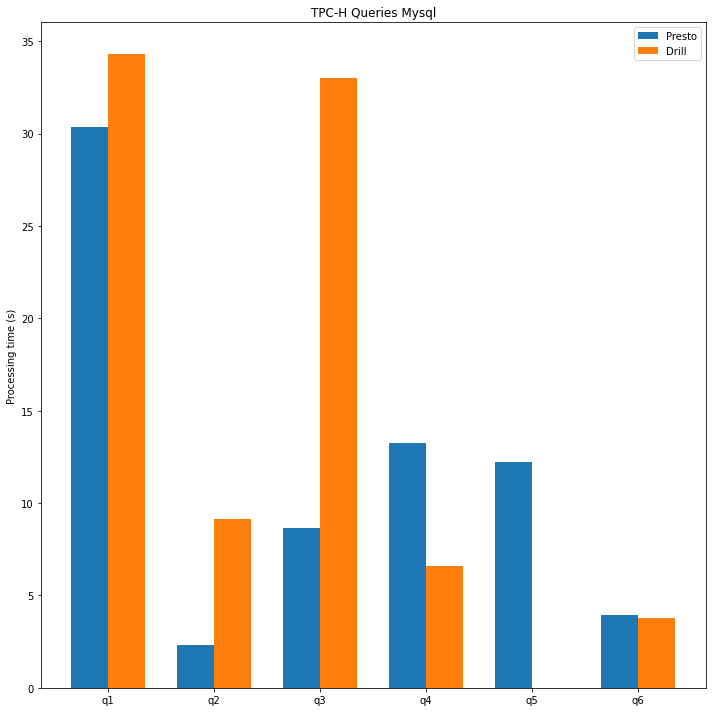

In [24]:
labels = sorted_query_keys[:6]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, presto_results.iloc[2][:6], width, label='Presto')
rects2 = ax.bar(x + width/2, drill_results.iloc[2][:6], width, label='Drill')

ax.set_ylabel('Processing time (s)')
ax.set_title('TPC-H Queries Mysql')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

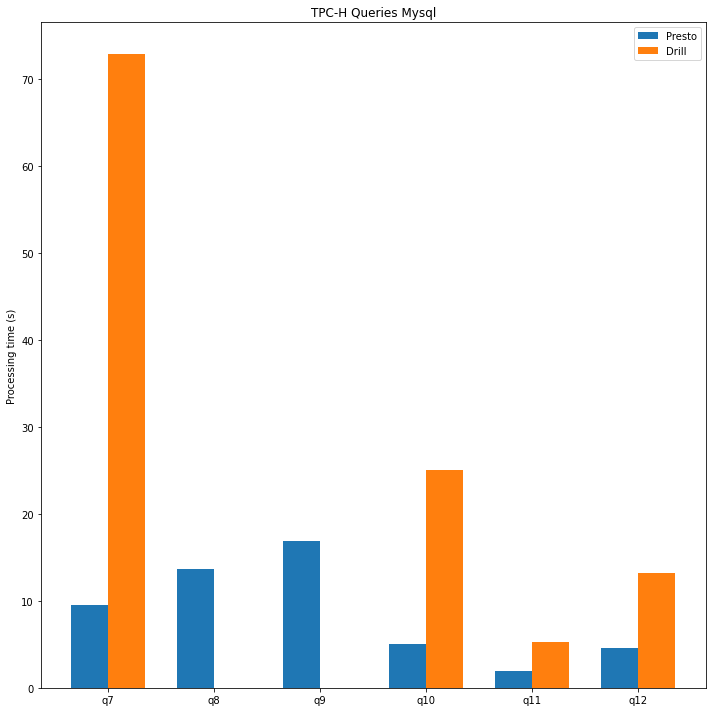

In [23]:
labels = sorted_query_keys[6:]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, presto_results.iloc[2][6:], width, label='Presto')
rects2 = ax.bar(x + width/2, drill_results.iloc[2][6:], width, label='Drill')

ax.set_ylabel('Processing time (s)')
ax.set_title('TPC-H Queries Mysql')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

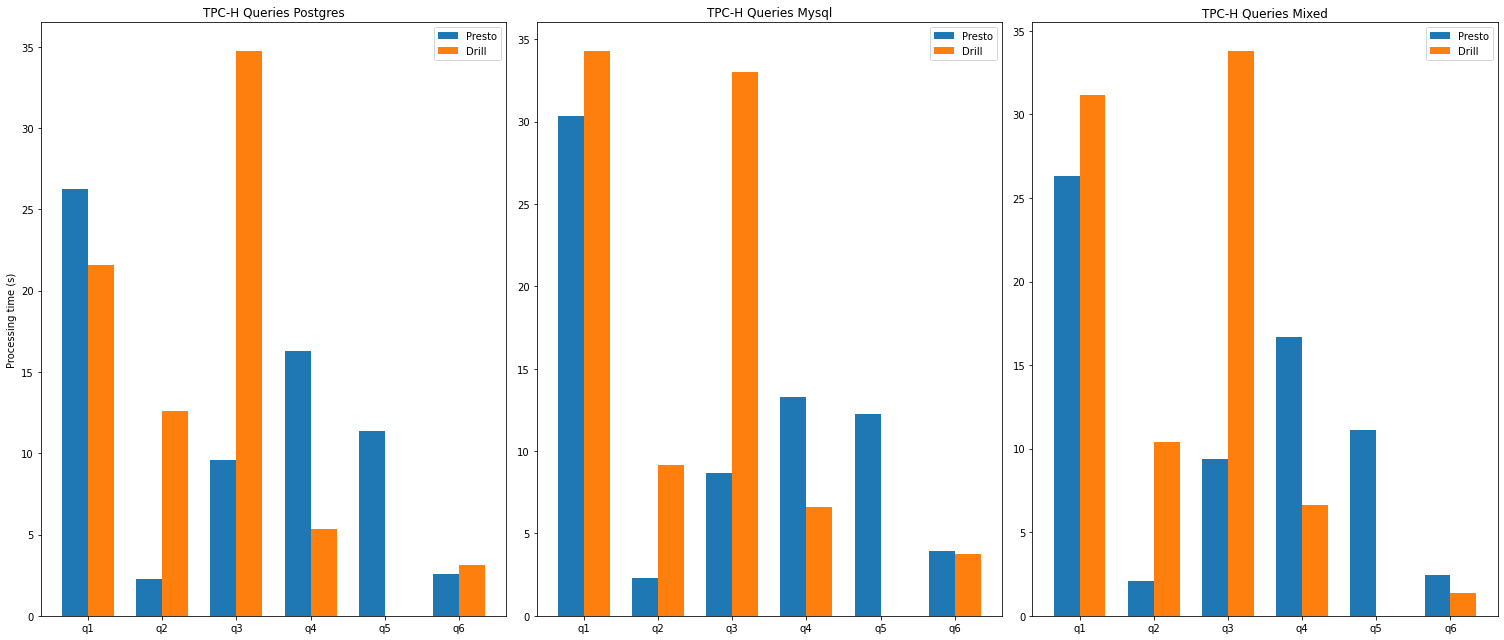

In [53]:
labels = sorted_query_keys[:6]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(21, 9))
rects1 = ax[2].bar(x - width/2, presto_results.iloc[0][:6], width, label='Presto')
rects2 = ax[2].bar(x + width/2, drill_results.iloc[0][:6], width, label='Drill')

ax[2].set_title('TPC-H Queries Mixed')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend()

rects1 = ax[0].bar(x - width/2, presto_results.iloc[1][:6], width, label='Presto')
rects2 = ax[0].bar(x + width/2, drill_results.iloc[1][:6], width, label='Drill')

ax[0].set_ylabel('Processing time (s)')
ax[0].set_title('TPC-H Queries Postgres')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

rects1 = ax[1].bar(x - width/2, presto_results.iloc[2][:6], width, label='Presto')
rects2 = ax[1].bar(x + width/2, drill_results.iloc[2][:6], width, label='Drill')

ax[1].set_title('TPC-H Queries Mysql')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

fig.tight_layout()

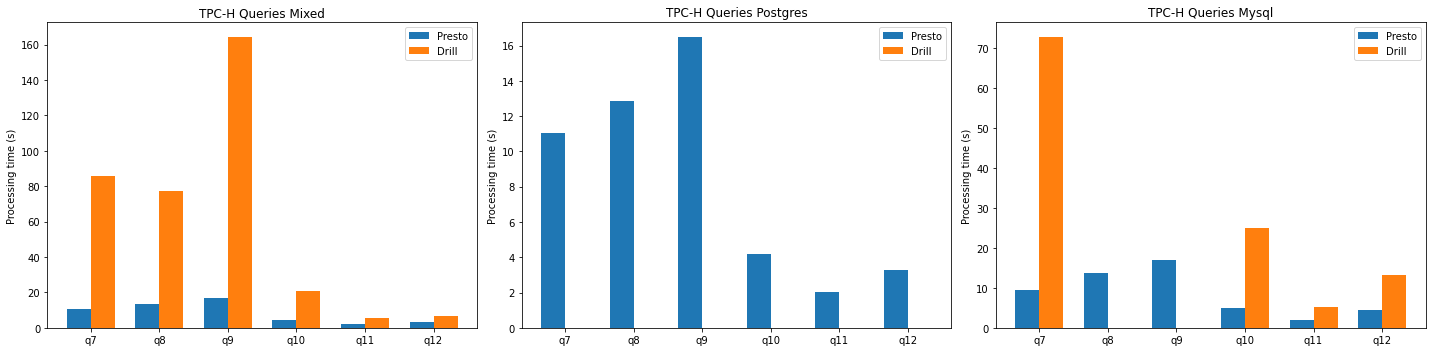

In [38]:
labels = sorted_query_keys[6:]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 5))
rects1 = ax[0].bar(x - width/2, presto_results.iloc[0][6:], width, label='Presto')
rects2 = ax[0].bar(x + width/2, drill_results.iloc[0][6:], width, label='Drill')

ax[0].set_ylabel('Processing time (s)')
ax[0].set_title('TPC-H Queries Mixed')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

rects1 = ax[1].bar(x - width/2, presto_results.iloc[1][6:], width, label='Presto')
rects2 = ax[1].bar(x + width/2, drill_results.iloc[1][6:], width, label='Drill')

ax[1].set_ylabel('Processing time (s)')
ax[1].set_title('TPC-H Queries Postgres')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

rects1 = ax[2].bar(x - width/2, presto_results.iloc[2][6:], width, label='Presto')
rects2 = ax[2].bar(x + width/2, drill_results.iloc[2][6:], width, label='Drill')

ax[2].set_ylabel('Processing time (s)')
ax[2].set_title('TPC-H Queries Mysql')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend()

fig.tight_layout()